In [21]:
%matplotlib inline

In [142]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import numpy.random as random
import os
import Image
import codecs, json

# <font color='green'>Load the data needed to fit the neural net</font>

### Get the names of the files and letters saved by the lettersketch app

In [17]:
dirName = "../lettersketch/assets/train_images/UpperCase/StraightLines/"
fileNames = []
fileLetters = []
for fileName in os.listdir(dirName):
    if fileName.endswith(".png") and (not "__" in fileName):
       fileNames.append(dirName+fileName)
       letter = fileName.split("_")[1]
       fileLetters.append(letter)
    
#print fileNames

### Read in the letters saved by the lettersketch app after converting into grayscale and resizing

In [74]:
#def rgb2gray(rgb):
#    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
#
#data = np.array([rgb2gray(mpimg.imread(fileName)) for fileName in fileNames], dtype = np.float64)
#data.shape

data = np.array([np.asarray(Image.open(fileName).convert('L').resize((28, 28), Image.NEAREST)) 
                 for fileName in fileNames], dtype = np.float64)
print data.shape

(61, 28, 28)


### Reshape the image arrays

In [75]:
data = data.reshape(data.shape[0], data.shape[1]*data.shape[2])
print data.shape

(61, 784)


### Convert white into black background

In [76]:
for dt in np.nditer(data, op_flags=['readwrite']):
    dt[...] = dt/255.0
    if (dt == 1.0):
        dt[...] = 0.0

### Load the test data, Convert white into black background, Reshape the data, and Plot a sample

In [79]:
testDirName = "../lettersketch/assets/test_images/"
testNames = []
for fileName in os.listdir(testDirName):
    if fileName.endswith(".png") and ("__" in fileName):
       testNames.append(testDirName+fileName)

testData = np.array([np.asarray(Image.open(fileName).convert('L').resize((28, 28), Image.NEAREST)) 
                 for fileName in testNames], dtype = np.float64)
print testData.shape

testData = testData.reshape(testData.shape[0], testData.shape[1]*testData.shape[2])
print testData.shape

for dt in np.nditer(testData, op_flags=['readwrite']):
    dt[...] = dt/255.0
    if (dt == 1.0):
        dt[...] = 0.0

(65, 28, 28)
(65, 784)


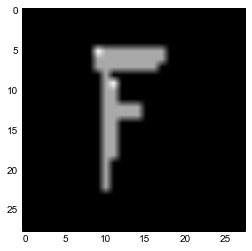

In [77]:
imgplot = plt.imshow(data[9].reshape(28,28), cmap="gray")

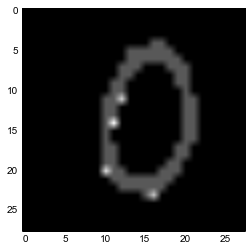

In [80]:
testplot = plt.imshow(testData[1].reshape(28,28), cmap ="gray")

### Create a label dictionary for the letters in the training set

In [61]:
labelDict = {'E':0, 'F':1, 'H':2, 'I':3, 'L':4, 'T':5}
print fileLetters

['E', 'L', 'L', 'F', 'F', 'H', 'F', 'H', 'F', 'F', 'I', 'F', 'L', 'E', 'H', 'F', 'L', 'I', 'F', 'L', 'L', 'E', 'F', 'H', 'T', 'F', 'I', 'I', 'L', 'H', 'I', 'T', 'I', 'T', 'L', 'L', 'H', 'I', 'E', 'E', 'I', 'I', 'T', 'T', 'F', 'H', 'T', 'E', 'H', 'E', 'F', 'E', 'L', 'F', 'E', 'T', 'F', 'L', 'H', 'T', 'T']


### Assign labels to the images in the training set

In [62]:
fileLabels = [labelDict[letter] for letter in fileLetters]
print fileLabels

[0, 4, 4, 1, 1, 2, 1, 2, 1, 1, 3, 1, 4, 0, 2, 1, 4, 3, 1, 4, 4, 0, 1, 2, 5, 1, 3, 3, 4, 2, 3, 5, 3, 5, 4, 4, 2, 3, 0, 0, 3, 3, 5, 5, 1, 2, 5, 0, 2, 0, 1, 0, 4, 1, 0, 5, 1, 4, 2, 5, 5]


### Vectorize the labels

In [63]:
def vectorizeLabels(label):
    vector = np.zeros((6))
    vector[label] = 1.0
    return vector

dataLabels = np.array([vectorizeLabels(label) for label in fileLabels])
print dataLabels[0]

[ 1.  0.  0.  0.  0.  0.]


### Join data and data labels

In [92]:
print data.shape
print dataLabels.shape
training_data = zip(data, dataLabels)
#print training_data[0]

(61, 784)
(61, 6)


In [67]:
%load nnutils.py

# <font color='green'>Utilities for working with a standard neural net</font>

In [94]:
#---------------------------------------------------
# A neural net class
#---------------------------------------------------
class NeuralNet(object):

  """ Constructor
  #   layers: vector of length numLayers containing the
  #          the number of neurons in each layer
  #           e.g., layers = (4, 3, 2) -> 4 input values, 3 neurons in hidden layer, 2 output values
  #   biases: initialized with random numbers except for first layer
  #           e.g., biases = [ [b11, b21, b31]^T, 
  #                            [b12, b22]^T ]
  #   weights: initialized with random numbers 
  #           e.g., [ [[w111, w121, w131, w141], 
  #                    [w211, w221, w231, w241],
  #                    [w311, w321, w331, w341]],
  #                   [[w112, w122, w132],
  #                    [w212, w222, w232]] ]
  """
  def __init__(self, layers):

    self.numLayers = len(layers)
    self.numNeurons = layers
    self.biases = [random.randn(layer, 1) for layer in layers[1:]]
    self.weights = [random.randn(layer2, layer1) 
                    for layer1, layer2 in zip(layers[:-1], layers[1:])]
    

  """ Batch stochastic gradient descent to find minimum of objective function
  #   training_data:  [(x1,y1),(x2,y2),....]
  #                   where x1, x2, x3, ... are input data vectors
  #                         y1, y2, y3, ... are labels
  #   max_iterations: number of iterations
  #   batch_size:     size of training batch
  #   learning_rate:  gradient descent parameter 
  """
  def batchStochasticGradientDescent(self, training_data, max_iterations, batch_size,
                                     learning_rate):

    # Get the number of training images
    nTrain = len(training_data)

    # Loop thru iterations
    for it in xrange(max_iterations):

      # Shuffle the training data
      random.shuffle(training_data)

      # Choose subsets of the training data
      batches = [ training_data[start:start+batch_size]
                  for start in xrange(0, nTrain, batch_size) ]

      # Loop thru subsets
      for batch in batches:
        self.updateBatch(batch, learning_rate)
      
      #print "Iteration {0} complete".format(it)
        
    #print "weights = ", self.weights
    #print "biases = ", self.biases

  """ Partial update of weights and biases using gradient descent
  #   with back propagation
  """
  def updateBatch(self, batch, learning_rate): 

    # Initialize gradC_w and gradC_b
    gradC_w = [np.zeros(w.shape) for w in self.weights]
    gradC_b = [np.zeros(b.shape) for b in self.biases]
    
    # Loop through samples in the batch
    for xx, yy in batch:
    
      # Compute correction to weights & biases using forward and backprop
      delta_gradC_w, delta_gradC_b = self.updateGradient(xx, yy)

      # Update the gradients
      gradC_w = [grad + delta_grad for grad, delta_grad in zip(gradC_w, delta_gradC_w)]
      gradC_b = [grad + delta_grad for grad, delta_grad in zip(gradC_b, delta_gradC_b)]

    # Update the weight and biases
    self.weights = [ weight - (learning_rate/len(batch))*grad
                     for weight, grad in zip(self.weights, gradC_w) ]
    self.biases  = [ bias - (learning_rate/len(batch))*grad
                     for bias, grad in zip(self.biases, gradC_b) ]

  # Forward and then backpropagation to compute the gradient of the objective function
  def updateGradient(self, xx, yy):

    # Reshape into column vectors
    xx = np.reshape(xx, (len(xx), 1))
    yy = np.reshape(yy, (len(yy), 1))
    
    # Initialize gradC_w and gradC_b
    gradC_w = [np.zeros(w.shape) for w in self.weights]
    gradC_b = [np.zeros(b.shape) for b in self.biases]

    # Compute forward pass through net
    # Initial activation value = input value
    activationValue = xx
    activationValues = [xx]
    layerOutputValues = []
    
    # Loop through layers
    for weight, bias in zip(self.weights, self.biases):

      #print weight.shape
      #print activationValue.shape
      layerOutputValue = np.dot(weight, activationValue) + bias
      layerOutputValues.append(layerOutputValue)

      activationValue = self.activationFunction(layerOutputValue)
      activationValues.append(activationValue)
      
    # Compute backpropagation corrections
    # Initial deltas
    delta = self.derivOfCostFunction(activationValues[-1], yy) * self.derivActivationFunction(layerOutputValues[-1])

    gradC_b[-1] = delta
    gradC_w[-1] = np.dot(delta, activationValues[-2].transpose())

    # Loop backward thru layers
    for layer in xrange(2, self.numLayers):

      layerOutputValue = layerOutputValues[-layer]
      derivActivation = self.derivActivationFunction(layerOutputValue)
  
      delta = np.dot(self.weights[-layer + 1].transpose(), delta)*derivActivation

      gradC_b[-layer] = delta
      gradC_w[-layer] = np.dot(delta, activationValues[-layer-1].transpose())
    
    # Return updated gradients
    return(gradC_w, gradC_b)

  # The activation function
  def activationFunction(self, xx):

    return 1.0/(1.0 + np.exp(-xx))

  # Derivative of activation function
  def derivActivationFunction(self, xx):

    return self.activationFunction(xx)*(1.0 - self.activationFunction(xx))
  
  # Derivative of the cost function with respect to output values
  def derivOfCostFunction(self, xx, yy):
    return (xx - yy)

  # The feedforward output computation for the network
  #   inputVector: (n, 1) array
  #                n = number of inputs to network
  #   outputVector: ????
  def forwardCompute(self, inputVector):

    for bias, weight in zip(self.biases, self.weights):
      xx = np.dot(weight, inputVector) + bias
      inputVector = self.activationFunction(xx)

    return inputVector
  

In [84]:
net = NeuralNet([4, 3, 2])

In [85]:
net.weights

[array([[-0.61807134,  0.5075986 ,  1.2595124 , -1.68576854],
        [-0.43087751,  0.75500013, -2.12123295,  0.94741883],
        [-0.60426656,  2.13093427,  1.02693772,  1.80040825]]),
 array([[ 0.03245494,  0.40785028,  0.12194416],
        [-0.42398392,  0.17104154, -1.25100685]])]

In [86]:
net.biases

[array([[-1.64218477],
        [-0.19587061],
        [-0.67338008]]), array([[ 0.46421977],
        [-0.70869281]])]

# <font color='green'>Fit the neural net to the input data</font>

In [95]:
testNN = NeuralNet([28*28, 49, 16, 6])
max_iterations = 100
batch_size = 1
learning_rate = 0.01
testNN.batchStochasticGradientDescent(training_data, max_iterations, batch_size,
                                     learning_rate)

### Save the weights and biases in JSON

In [151]:
weightsList = testNN.weights
for weights in weightsList:
    print weights.shape
    
biasesList = testNN.biases
for biases in biasesList:
    print biases.shape

(49, 784)
(16, 49)
(6, 16)
(49, 1)
(16, 1)
(6, 1)


In [153]:

weightsFileName = "../lettersketch/assets/json/UpperCase_StraightLines_weights.json"
biasesFileName = "../lettersketch/assets/json/UpperCase_StraightLines_biases.json"
for weights in weightsList:
  json.dump(weights.tolist(), codecs.open(weightsFileName, 'a', encoding='utf-8'),
    separators=(',', ':'), sort_keys=True, indent=2)

for biases in biasesList:
  json.dump(biases.tolist(), codecs.open(biasesFileName, 'a', encoding='utf-8'),
    separators=(',', ':'), sort_keys=True, indent=2)

# <font color='green'>Test how well the model is performing</font>

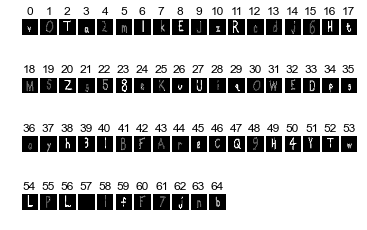

In [131]:
fig = plt.figure()

num_image_rows = np.ceil(np.sqrt(testData.shape[0]))
for i in range(0, testData.shape[0]):
  a = fig.add_subplot(num_image_rows/2, num_image_rows*2, i+1)
  a.set_title(i)
  testplot = plt.imshow(testData[i].reshape(28,28), cmap ="gray")
  plt.axis('off')

In [141]:
result = testNN.forwardCompute(np.reshape(testData[60], (28*28,1)))
letterIndex = np.argmax(result)
print letterIndex
print labelDict.keys()[labelDict.values().index(letterIndex)]

1
F
